### Train-Test Split

In [ ]:
import numpy as np
import pandas as pd

post_pre=pd.read_csv('post_data.csv')

In [ ]:
from sklearn.model_selection import train_test_split

x_tr, x_val, = train_test_split(
    np.array(post_pre["text"]),
    test_size=0.2,
    random_state=0,
    shuffle=True,
)

In [ ]:
print(x_tr.shape)
print(x_val.shape)

(32931,)
(8233,)


In [ ]:
# Tokenize the text to get the vocab count
from keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences

# Prepare a tokenizer on training data
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(x_tr))

In [ ]:
#occurence of rare words
thresh = 5

cnt = 0
tot_cnt = 0

for key, value in x_tokenizer.word_counts.items():
    tot_cnt = tot_cnt + 1
    if value < thresh:
        cnt = cnt + 1
print(tot_cnt)
print(cnt)
words = tot_cnt - cnt
print("% of rare words in vocabulary: ", (cnt / tot_cnt) * 100)
print((words))

127429
86652
% of rare words in vocabulary:  68.0002197302027
40777


In [ ]:
word_counts = x_tokenizer.word_counts
thresh = 5

# Create a new dictionary for words that occur more than the thresh value
words_dict = {}
for word, count in word_counts.items():
    if count >= thresh:
        words_dict[word] = count

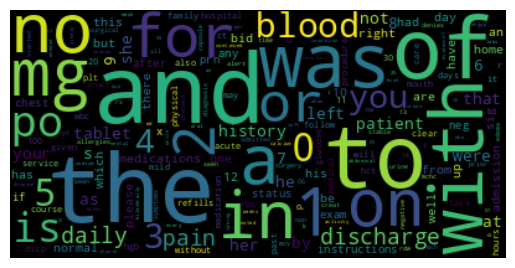

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate the word cloud
wordcloud = WordCloud().generate_from_frequencies(words_dict)

# Display the word cloud
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

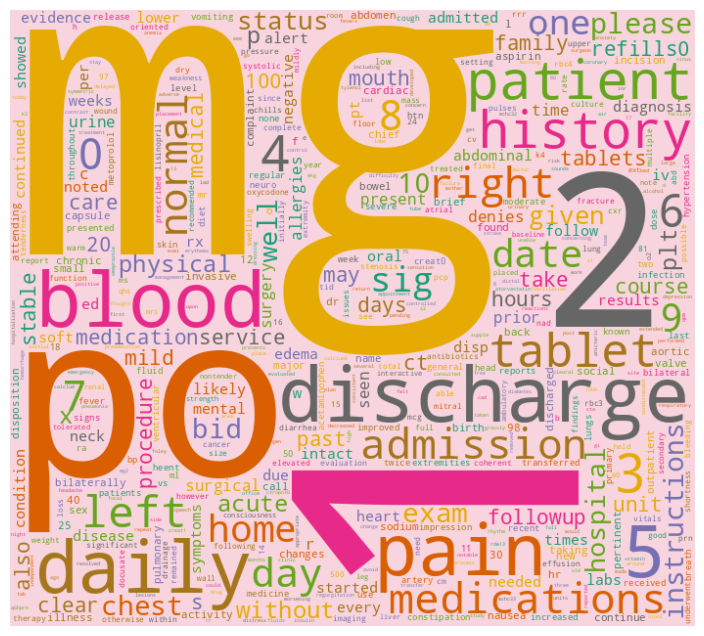

In [ ]:
from textwrap import wrap
title='WordCloud'
wc = WordCloud(width=700, height=630, background_color="#f8d5de",max_words=500,colormap="Dark2").generate_from_frequencies(words_dict)
plt.figure(figsize=(10,8))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
#plt.title('\n'.join(wrap(title,60)),fontsize=13)
plt.show()

In [ ]:
sorted_word_counts = dict(sorted(words_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_word_counts)

{'and': 56306, 'the': 55230, 'to': 46386, 'of': 44402, 'was': 32082, 'with': 31696, 'no': 28461, 'a': 27231, '1': 26167, 'mg': 24565, 'in': 24017, 'on': 23916, 'for': 23475, 'or': 20966, '2': 20885, 'po': 19824, 'is': 17346, '0': 16968, 'discharge': 16280, '3': 15933, '5': 15898, 'blood': 15627, '4': 14744, 'daily': 14731, 'you': 14680, 'pain': 14475, 'she': 13967, 'your': 13915, 'patient': 13060, 'he': 12779, 'at': 12247, 'tablet': 12096, 'as': 11345, 'history': 11258, '6': 10187, 'not': 9422, '8': 9152, 'her': 8815, 'by': 8772, '7': 8740, 'were': 8239, 'left': 8204, '9': 7812, 'medications': 7758, 'that': 7603, 's': 7542, 'admission': 7524, 'this': 7333, 'right': 7312, 'normal': 6922, 'his': 6916, 'be': 6583, 'day': 6532, '10': 6445, 'had': 6200, 'date': 6168, 'have': 6090, 'from': 5938, 'has': 5655, 'home': 5646, 'up': 5641, 'are': 5482, 'please': 5466, 'but': 5149, 'one': 5105, 'an': 4947, 'sig': 4863, '12': 4821, 'well': 4720, 'which': 4627, 'x': 4558, 'there': 4547, 'instructions

In [ ]:
# Prepare a tokenizer, again -- by not considering the rare words
x_tokenizer = Tokenizer(num_words = tot_cnt - cnt)
x_tokenizer.fit_on_texts(list(x_tr))

# Convert text sequences to integer sequences
x_tr_seq = x_tokenizer.texts_to_sequences(x_tr)
x_val_seq = x_tokenizer.texts_to_sequences(x_val)

# Pad zero upto maximum length
x_tr = pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val = pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

# Size of vocabulary (+1 for padding token)
x_voc = x_tokenizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 40778


In [ ]:
len(x_tokenizer.word_counts)

81134

In [ ]:
x_tokenizer.num_words

28355

### Building the model

In [ ]:
from keras.preprocessing.text import Tokenizer
#from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.layers import Input, LSTM, Embedding, Dense, \
    Concatenate, TimeDistributed, RepeatVector, Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.losses import mse

In [ ]:
# Define the input shape for the encoder and decoder
input_shape = (max_text_len,)

# Define the size of the embedding layer
embedding_size = 300

# Define the size of the LSTM layer
lstm_size = 256

# Define the vocabulary size (i.e., the number of unique words in the input data)
vocab_size = x_voc

# Define the encoder
encoder_input = Input(shape=input_shape)
encoder_embedding = Embedding(vocab_size, embedding_size, mask_zero=True)(encoder_input)
encoder_lstm = LSTM(lstm_size, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

In [ ]:
# Define the decoder
#decoder_input = Input(shape=input_shape)
#decoder_embedding = Embedding(vocab_size, embedding_size, mask_zero=True)(decoder_input)
decoder_lstm = LSTM(lstm_size, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(encoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(vocab_size, activation='softmax')
decoder_output = decoder_dense(decoder_output)

In [ ]:
# Define the model
#model = Model([encoder_input, decoder_input], decoder_output)
model=Model(encoder_input, decoder_output)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 5000)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 5000, 300)    12233400    ['input_2[0][0]']                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 256),        570368      ['embedding_1[0][0]']            
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

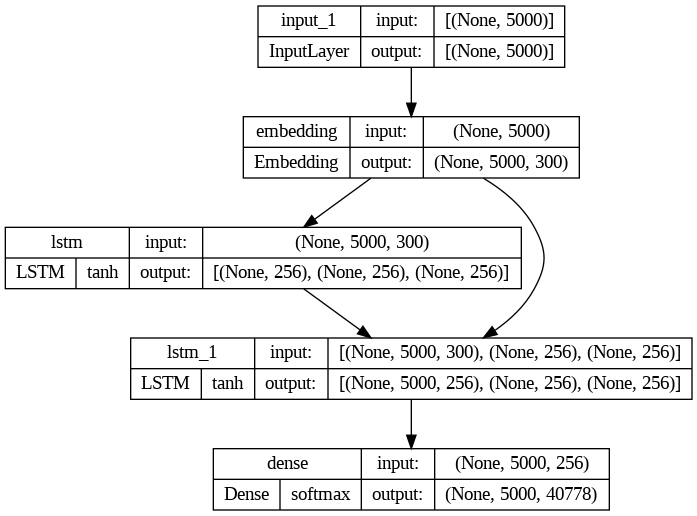

In [ ]:
from keras.utils.vis_utils import plot_model
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, show_layer_activations=True)

In [ ]:
# compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history=model.fit(x_tr, x_tr, batch_size=4, epochs=10)

In [ ]:
model.save('meddoc_final.h5')

In [ ]:
import pickle
#
# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(x_tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

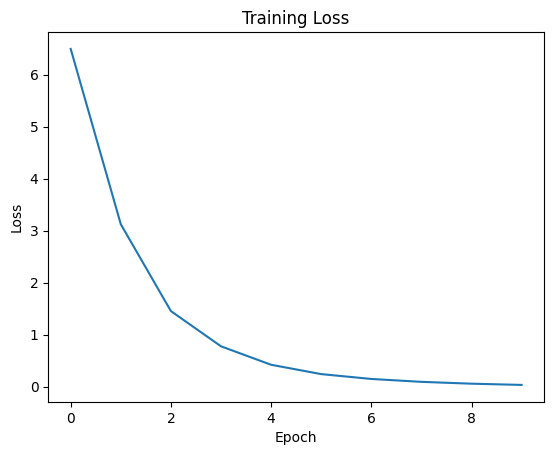

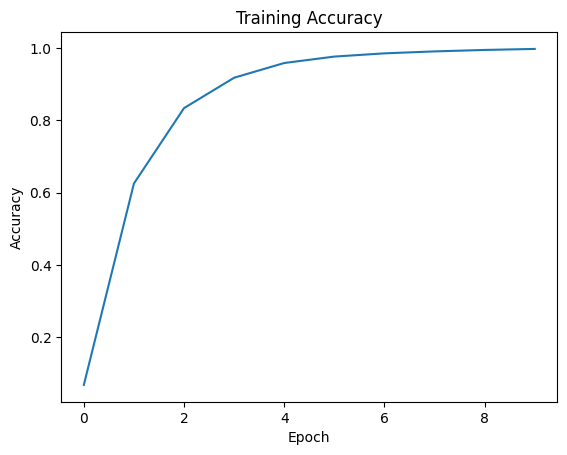

In [ ]:
import matplotlib.pyplot as plt # Plot training loss
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# Plot training accuracy
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()
